# Basis Function Regression con Kernel

### Autor: Carlos Andrés Arroyave
### Fecha : 27 Agosto 2025
### Mail :  caarroyave1@correo.iue.edu.co
### Movil : 3015813032
### Actividad :  Proyecto final



CARGANDO BASE DE DATOS DE DIABETES
Datos cargados: (442, 10)
Target range: 25.0 - 346.0
DISTRIBUCIÓN DE CLASES PARA CLASIFICACIÓN:
  Clase Muy Bajo: 112 muestras (25.3%)
  Clase Bajo: 109 muestras (24.7%)
  Clase Alto: 110 muestras (24.9%)
  Clase Muy Alto: 111 muestras (25.1%)
MODELO DE REGRESIÓN CON VALIDACIÓN CRUZADA:


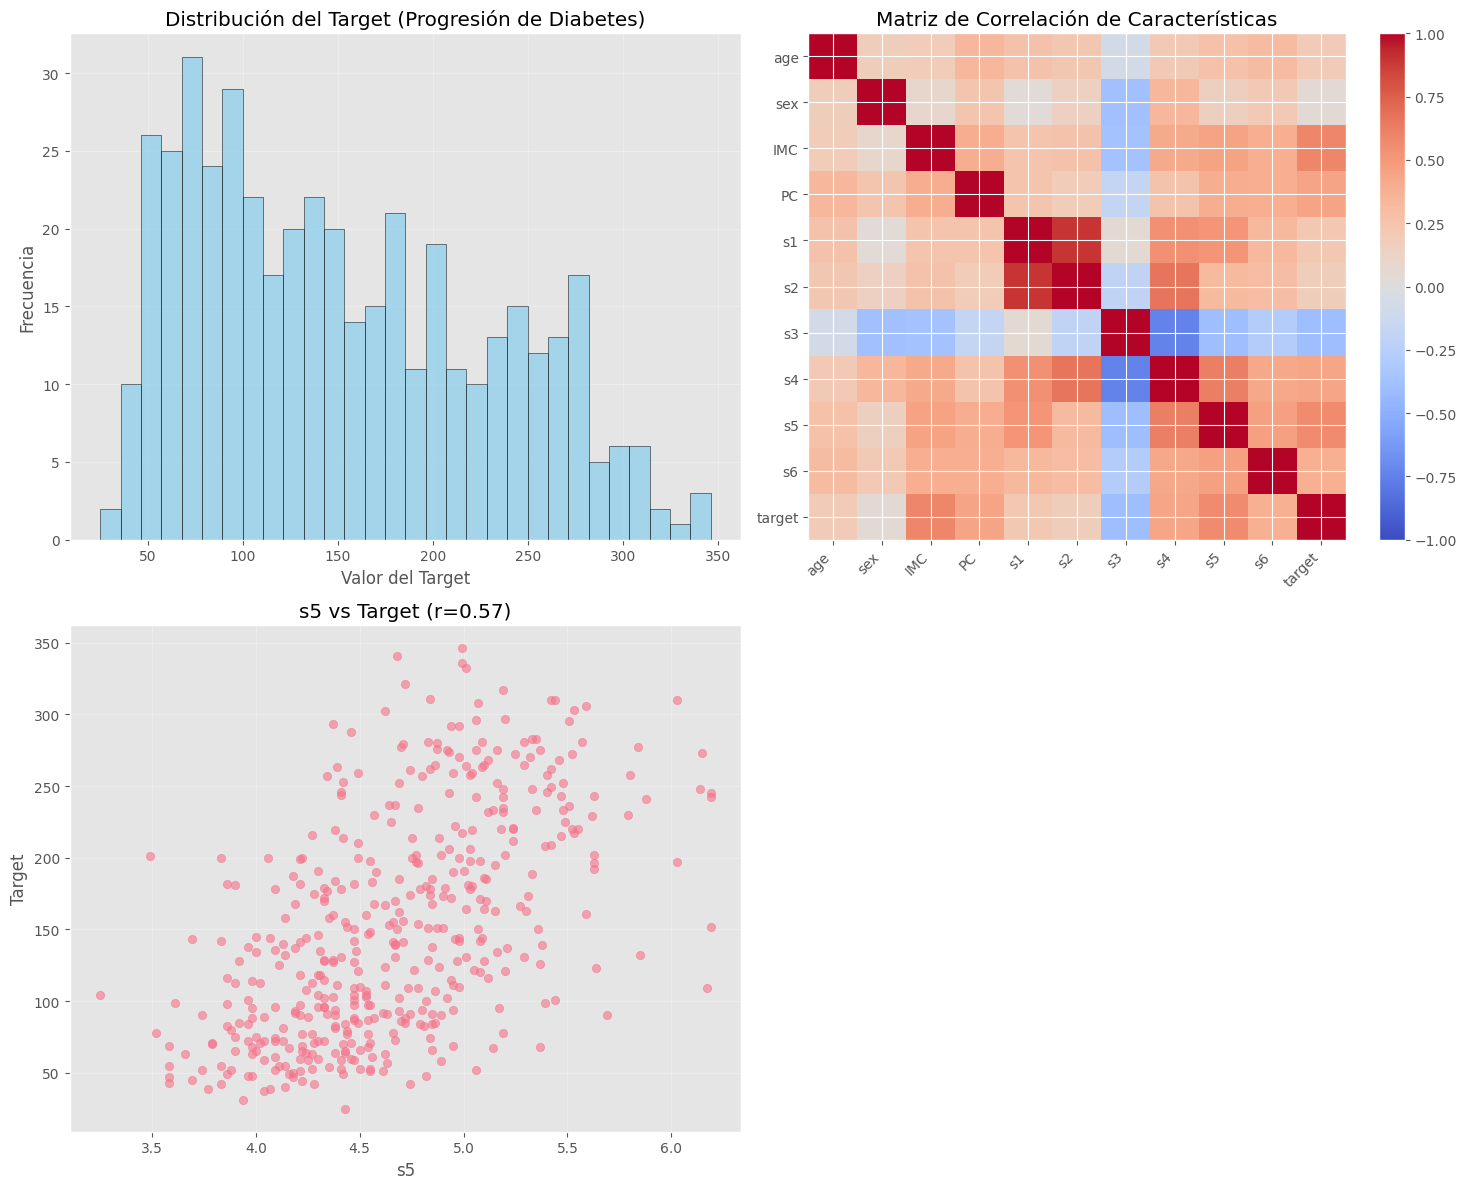

Datos preparados:
Regresión - Entrenamiento: (353, 10), Prueba: (89, 10)
Clasificación - Entrenamiento: (353, 10), Prueba: (89, 10)

ENTRENANDO MODELOS DE REGRESIÓN
MODELO: SVR - KERNEL: linear
   RMSE: 54.2367
   NRMSE: 0.1987
   CV RMSE: 55.6712 (±2.4187)
   Tiempo de entrenamiento: 0.0017s
MODELO: GPR - KERNEL: linear
   RMSE: 53.8999
   NRMSE: 0.1974
   CV RMSE: 55.9570 (±3.1952)
   Tiempo de entrenamiento: 0.1446s
MODELO: SVR - KERNEL: rbf
   RMSE: 65.8304
   NRMSE: 0.2411
   CV RMSE: 72.5384 (±7.7850)
   Tiempo de entrenamiento: 0.0055s
MODELO: GPR - KERNEL: rbf
   RMSE: 84.3332
   NRMSE: 0.3089
   CV RMSE: 91.3511 (±11.3659)
   Tiempo de entrenamiento: 0.1890s
MODELO: SVR - KERNEL: poly
   RMSE: 61.6564
   NRMSE: 0.2258
   CV RMSE: 69.5940 (±5.2179)
   Tiempo de entrenamiento: 0.0068s
MODELO: GPR - KERNEL: poly
   RMSE: 51.3778
   NRMSE: 0.1882
   CV RMSE: 56.1646 (±3.7746)
   Tiempo de entrenamiento: 0.6331s

ENTRENANDO MODELO DE CLASIFICACIÓN
MODELO: Logistic - KERNEL: N/A
   

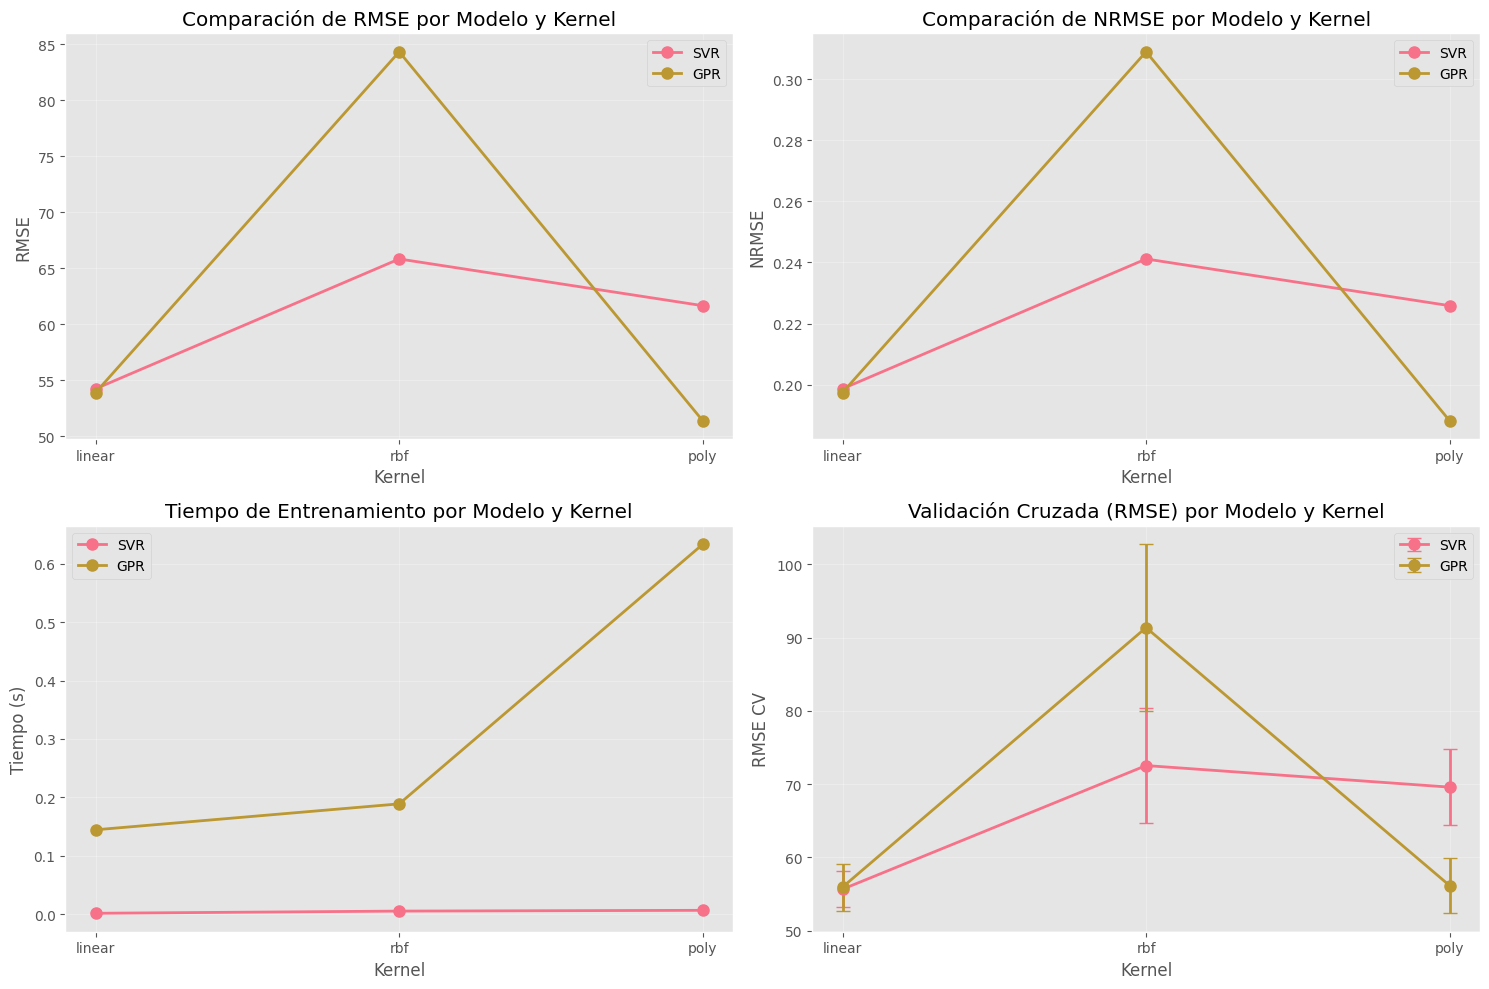


TABLA COMPLETA DE RESULTADOS
     Modelo  Kernel     RMSE   NRMSE  Accuracy  CV_MEAN   CV_STD  Tiempo
0       SVR  linear  54.2367  0.1987       NaN  55.6712   2.4187  0.0017
1       GPR  linear  53.8999  0.1974       NaN  55.9570   3.1952  0.1446
2       SVR     rbf  65.8304  0.2411       NaN  72.5384   7.7850  0.0055
3       GPR     rbf  84.3332  0.3089       NaN  91.3511  11.3659  0.1890
4       SVR    poly  61.6564  0.2258       NaN  69.5940   5.2179  0.0068
5       GPR    poly  51.3778  0.1882       NaN  56.1646   3.7746  0.6331
6  Logistic     N/A      NaN     NaN    0.4719   0.4985   0.0217  0.0072


In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, DotProduct, Matern
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
import time
import warnings
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')

# Configuración
plt.style.use('ggplot')
sns.set_palette("husl")
np.random.seed(42)

# 1. Cargar base de datos de diabetes
print("="*60)
print("CARGANDO BASE DE DATOS DE DIABETES")
print("="*60)

feature_names = ['age', 'sex', 'IMC', 'PC', 's1', 's2', 's3', 's4', 's5', 's6']
df = pd.read_csv('diabetes.txt', sep='\s+', names=feature_names + ['target'])
X = df.drop('target', axis=1).values
y = df['target'].values

print(f"Datos cargados: {X.shape}")
print(f"Target range: {y.min()} - {y.max()}")

# Para clasificación, crear categorías basadas en cuartiles
print("="*60)
print("DISTRIBUCIÓN DE CLASES PARA CLASIFICACIÓN:")
print("="*60)

y_class = pd.qcut(y, q=4, labels=False)  # 4 categorías
class_names = ['Muy Bajo', 'Bajo', 'Alto', 'Muy Alto']
for i, count in enumerate(np.bincount(y_class)):
    print(f"  Clase {class_names[i]}: {count} muestras ({count/len(y_class)*100:.1f}%)")
print("="*60)

print("="*60)
print("MODELO DE REGRESIÓN CON VALIDACIÓN CRUZADA:")
print("="*60)

def plot_diabetes_data(X, y, feature_names):
    """
    Visualización del dataset de diabetes
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Distribución del target
    axes[0,0].hist(y, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_title('Distribución del Target (Progresión de Diabetes)')
    axes[0,0].set_xlabel('Valor del Target')
    axes[0,0].set_ylabel('Frecuencia')
    axes[0,0].grid(alpha=0.3)
    
    # Correlación de características
    df_temp = pd.DataFrame(X, columns=feature_names)
    df_temp['target'] = y
    corr_matrix = df_temp.corr()
    
    im = axes[0,1].imshow(corr_matrix.values, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    axes[0,1].set_title('Matriz de Correlación de Características')
    axes[0,1].set_xticks(range(len(feature_names) + 1))
    axes[0,1].set_yticks(range(len(feature_names) + 1))
    axes[0,1].set_xticklabels(feature_names + ['target'], rotation=45, ha='right')
    axes[0,1].set_yticklabels(feature_names + ['target'])
    plt.colorbar(im, ax=axes[0,1])
    
    # Relación entre las dos características más importantes y el target
    #correlations = np.corrcoef(np.column_stack((X.T, y)))[-1, :-1]
    correlations = np.corrcoef(np.column_stack((X, y)), rowvar=False)[-1, :-1]

    top_features_idx = np.argsort(np.abs(correlations))[-2:]
    
    for i, idx in enumerate(top_features_idx):
        axes[1,i].scatter(X[:, idx], y, alpha=0.6, color=f'C{i}')
        axes[1,i].set_xlabel(feature_names[idx])
        axes[1,i].set_ylabel('Target')
        axes[1,i].set_title(f'{feature_names[idx]} vs Target (r={correlations[idx]:.2f})')
        axes[1,i].grid(alpha=0.3)
    
    
    # Espacio vacío para el cuarto subplot
    axes[1,1].set_visible(False)
    
    plt.tight_layout()
    plt.show()

plot_diabetes_data(X, y, feature_names)

# Preprocesamiento para modelos de regresión
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Escalar datos para regresión
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

# Preprocesamiento para clasificación
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y_class, test_size=0.2, random_state=42, stratify=y_class
)

# Escalar datos para clasificación
scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

print("Datos preparados:")
print(f"Regresión - Entrenamiento: {X_train_reg_scaled.shape}, Prueba: {X_test_reg_scaled.shape}")
print(f"Clasificación - Entrenamiento: {X_train_clf_scaled.shape}, Prueba: {X_test_clf_scaled.shape}")

def calcular_rmse_nrmse(y_real, y_pred):
    """
    Calcula el RMSE y NRMSE de forma manual.
    Fórmula: RMSE = sqrt( (1/n) * Σ (y_i - ŷ_i)^2 )
    Fórmula: NRMSE = RMSE / (max(y) - min(y))
    """
    y_real = np.array(y_real).flatten()
    y_pred = np.array(y_pred).flatten()
    
    n = len(y_real)
    error_cuadrado = (y_real - y_pred) ** 2
    mse = np.sum(error_cuadrado) / n  
    rmse = np.sqrt(mse)
    
    # NRMSE normalizado por el rango de los datos reales
    nrmse = rmse / (y_real.max() - y_real.min())
    
    return rmse, nrmse

def train_kernel_model(X_train, y_train, X_test, y_test, model_name, kernel_type='rbf'):
    """
    Entrena y evalúa diferentes modelos con kernels
    """
    print("=" * 60)
    print(f"MODELO: {model_name} - KERNEL: {kernel_type}")
    print("=" * 60)
   
    # Configurar modelo según el tipo
    if model_name == 'SVR':
        model = SVR(kernel=kernel_type, C=1.0, epsilon=0.1)
    
    elif model_name == 'GPR':  # Cambiado de KRR a GPR (Gaussian Process Regression)
        # Configurar kernel según el tipo
        if kernel_type == 'rbf':
            kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
        elif kernel_type == 'linear':
            kernel = DotProduct()
        elif kernel_type == 'poly':
            kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2)) + DotProduct() ** 2
        else:
            kernel = RBF()  # Por defecto
        
        model = GaussianProcessRegressor(kernel=kernel, random_state=42, n_restarts_optimizer=5)
    
    elif model_name == 'Logistic':
        # Solo para clasificación, no para regresión
        model = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr')
        # Usar datos de clasificación
        X_train_used = X_train_clf_scaled
        X_test_used = X_test_clf_scaled
        y_train_used = y_train_clf
        y_test_used = y_test_clf
    else:
        raise ValueError("Modelo no soportado. Use 'SVR', 'GPR' o 'Logistic'.")
    
    # Para modelos de regresión, usar datos de regresión
    if model_name != 'Logistic':
        X_train_used = X_train
        X_test_used = X_test
        y_train_used = y_train
        y_test_used = y_test
    
    # Entrenar y predecir
    start_time = time.time()
    model.fit(X_train_used, y_train_used)
    train_time = time.time() - start_time
    
    y_pred = model.predict(X_test_used)
    
    # Calcular métricas según el tipo de problema
    if model_name == 'Logistic':
        # Para clasificación
        accuracy = np.mean(y_pred == y_test_used)
        print(f"   Accuracy: {accuracy:.4f}")
        rmse, nrmse = np.nan, np.nan  # No aplicable para clasificación
    else:
        # Para regresión
        rmse, nrmse = calcular_rmse_nrmse(y_test_used, y_pred)
        print(f"   RMSE: {rmse:.4f}")
        print(f"   NRMSE: {nrmse:.4f}")
    
    # Validación cruzada (solo para regresión)
    if model_name != 'Logistic':
        cv_scores = cross_val_score(model, X_train_used, y_train_used, cv=5, 
                                  scoring='neg_mean_squared_error')
        cv_rmse = np.sqrt(-cv_scores)
        print(f"   CV RMSE: {cv_rmse.mean():.4f} (±{cv_rmse.std():.4f})")
        cv_mean = cv_rmse.mean()
        cv_std = cv_rmse.std()
    else:
        cv_scores = cross_val_score(model, X_train_used, y_train_used, cv=5, scoring='accuracy')
        print(f"   CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
    
    print(f"   Tiempo de entrenamiento: {train_time:.4f}s")
    
    result = {
        'Modelo': model_name,
        'Kernel': kernel_type,
        'RMSE': rmse if model_name != 'Logistic' else np.nan,
        'NRMSE': nrmse if model_name != 'Logistic' else np.nan,
        'Accuracy': accuracy if model_name == 'Logistic' else np.nan,
        'CV_MEAN': cv_mean,
        'CV_STD': cv_std,
        'Tiempo': train_time
    }
    
    return result

# Entrenar modelos
kernels = ['linear', 'rbf', 'poly']
model_results = []

print("\n" + "="*60)
print("ENTRENANDO MODELOS DE REGRESIÓN")
print("="*60)

for kernel in kernels:
    # Modelos de regresión
    model_results.append(
        train_kernel_model(X_train_reg_scaled, y_train_reg, X_test_reg_scaled, y_test_reg, 'SVR', kernel)
    )
    model_results.append(
        train_kernel_model(X_train_reg_scaled, y_train_reg, X_test_reg_scaled, y_test_reg, 'GPR', kernel)
    )

print("\n" + "="*60)
print("ENTRENANDO MODELO DE CLASIFICACIÓN")
print("="*60)

# Modelo de clasificación (sin kernel parameter)
model_results.append(
    train_kernel_model(None, None, None, None, 'Logistic', 'N/A')
)

# Crear DataFrame de resultados
df_resultados = pd.DataFrame(model_results)

# Mostrar mejores resultados
print("\n" + "="*60)
print("MEJORES RESULTADOS")
print("="*60)

# Para regresión
reg_results = df_resultados[df_resultados['Modelo'].isin(['SVR', 'GPR'])]
if not reg_results.empty:
    mejor_regresion = reg_results.loc[reg_results['RMSE'].idxmin()]
    print(f"Mejor modelo de regresión: {mejor_regresion['Modelo']} ({mejor_regresion['Kernel']})")
    print(f"RMSE: {mejor_regresion['RMSE']:.4f}, NRMSE: {mejor_regresion['NRMSE']:.4f}")

# Para clasificación
clf_results = df_resultados[df_resultados['Modelo'] == 'Logistic']
if not clf_results.empty:
    mejor_clasificacion = clf_results.iloc[0]
    print(f"Modelo de clasificación - Accuracy: {mejor_clasificacion['Accuracy']:.4f}")

# Gráficas comparativas
plt.figure(figsize=(15, 10))

# Gráfica 1: Comparación de RMSE
plt.subplot(2, 2, 1)
for modelo in ['SVR', 'GPR']:
    datos = df_resultados[(df_resultados['Modelo'] == modelo) & (df_resultados['Kernel'].isin(kernels))]
    if not datos.empty:
        plt.plot(datos['Kernel'], datos['RMSE'], 'o-', label=modelo, markersize=8, linewidth=2)
plt.title('Comparación de RMSE por Modelo y Kernel')
plt.xlabel('Kernel')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfica 2: Comparación de NRMSE
plt.subplot(2, 2, 2)
for modelo in ['SVR', 'GPR']:
    datos = df_resultados[(df_resultados['Modelo'] == modelo) & (df_resultados['Kernel'].isin(kernels))]
    if not datos.empty:
        plt.plot(datos['Kernel'], datos['NRMSE'], 'o-', label=modelo, markersize=8, linewidth=2)
plt.title('Comparación de NRMSE por Modelo y Kernel')
plt.xlabel('Kernel')
plt.ylabel('NRMSE')
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfica 3: Tiempos de entrenamiento
plt.subplot(2, 2, 3)
for modelo in ['SVR', 'GPR']:
    datos = df_resultados[(df_resultados['Modelo'] == modelo) & (df_resultados['Kernel'].isin(kernels))]
    if not datos.empty:
        plt.plot(datos['Kernel'], datos['Tiempo'], 'o-', label=modelo, markersize=8, linewidth=2)
plt.title('Tiempo de Entrenamiento por Modelo y Kernel')
plt.xlabel('Kernel')
plt.ylabel('Tiempo (s)')
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfica 4: Resultados de validación cruzada
plt.subplot(2, 2, 4)
for modelo in ['SVR', 'GPR']:
    datos = df_resultados[(df_resultados['Modelo'] == modelo) & (df_resultados['Kernel'].isin(kernels))]
    if not datos.empty:
        plt.errorbar(datos['Kernel'], datos['CV_MEAN'], yerr=datos['CV_STD'], 
                    fmt='o-', label=modelo, markersize=8, linewidth=2, capsize=5)
plt.title('Validación Cruzada (RMSE) por Modelo y Kernel')
plt.xlabel('Kernel')
plt.ylabel('RMSE CV')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Mostrar tabla de resultados completa
print("\n" + "="*60)
print("TABLA COMPLETA DE RESULTADOS")
print("="*60)
print(df_resultados.round(4))
